<a href="https://colab.research.google.com/github/tibaris/EntropicSparsificationNN/blob/main/swiss-roll-extract-layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage import io, exposure

import numpy as np
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy.ndimage import gaussian_filter

import time
from skimage.color import rgb2gray
from skimage.transform import rescale

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched

import csv
import pandas as pd
import time
import gc
import sys

In [3]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Case 1: One turn

In [ ]:
train_data = pd.read_csv("/content/swissroll-10000-turn1.csv", header=None)
train_data = train_data.to_numpy()

In [ ]:
train_data = np.transpose(train_data)
train_data = torch.from_numpy(train_data)
print(train_data.shape)

train_num = train_data.shape[0]
torch.manual_seed(0)
permutation = torch.randperm(train_num)

train_x = train_data[permutation[:15000],:]
train_y = (permutation[:15000]<train_num/2)*1
train_x = train_x.reshape([train_x.shape[0],train_x.shape[1],1,1])
print(train_x.shape)
print(train_y.shape)

torch.Size([20000, 2])
torch.Size([15000, 2, 1, 1])
torch.Size([15000])


In [ ]:
class SimplePerceptron(nn.Module):

    def __init__(self):
        super(SimplePerceptron, self).__init__()
        self.conv1 = nn.Conv2d(2,400,kernel_size = (1,1))
        self.conv2 = nn.Conv2d(400,400,kernel_size = (1,1))
        self.conv3 = nn.Conv2d(400,1,kernel_size = (1,1))

        self.bn1 = nn.BatchNorm2d(400, affine=False)
        self.bn2 = nn.BatchNorm2d(400, affine=False)


    def forward(self, x):
        #1st  layer
        #x = self.bn1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        #x = F.softmax(x)
        x = F.sigmoid(x)
        return x

    def forward_conv1(self, x):
        y = self.conv1(x)
        return (x,y)

    def forward_conv2(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        y = self.conv2(x)
        return (x,y)

    def forward_conv3(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        y = self.conv3(x)
        return (x,y)

In [ ]:
model = SimplePerceptron().double()
print(count_parameters(model))

162001


In [ ]:
model.load_state_dict(torch.load("/content/FCC-swiss-roll-1turn-10k.pth"))
model.eval()

SimplePerceptron(
  (conv1): Conv2d(2, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(400, 1, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn2): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [ ]:
(x_l1, y_l1) = model.forward_conv1(train_x)
(x_l2, y_l2) = model.forward_conv2(train_x)
(x_l3, y_l3) = model.forward_conv3(train_x)

In [ ]:
#pd.DataFrame(x_l1[:,:,0,0].detach().numpy()).to_csv("model1-layer1-Xtrain.csv")
#pd.DataFrame(y_l1[:,:,0,0].detach().numpy()).to_csv("model1-layer1-Ytrain.csv")

#pd.DataFrame(x_l2[:,:,0,0].detach().numpy()).to_csv("model1-layer2-Xtrain.csv")
#pd.DataFrame(y_l2[:,:,0,0].detach().numpy()).to_csv("model1-layer2-Ytrain.csv")

#pd.DataFrame(x_l3[:,:,0,0].detach().numpy()).to_csv("model1-layer3-Xtrain.csv")
#pd.DataFrame(y_l3[:,:,0,0].detach().numpy()).to_csv("model1-layer3-Ytrain.csv")

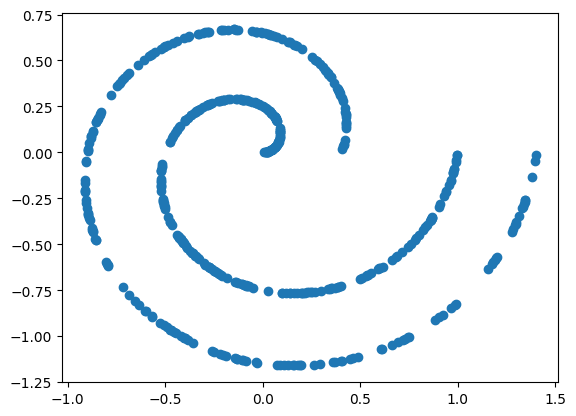

In [ ]:
plot_x = train_x[:500]
plot_x.shape

plt.scatter(plot_x[:,0,0,0], plot_x[:,1,0,0])

# Case 2: Two turns

In [4]:
train_data = pd.read_csv("/content/swissroll-10000-turn2.csv", header=None)
train_data = train_data.to_numpy()

In [5]:
train_data = np.transpose(train_data)
train_data = torch.from_numpy(train_data)
print(train_data.shape)

train_num = train_data.shape[0]
torch.manual_seed(0)
permutation = torch.randperm(train_num)

train_x = train_data[permutation[:15000],:]
train_y = (permutation[:15000]<train_num/2)*1
train_x = train_x.reshape([train_x.shape[0],train_x.shape[1],1,1])
print(train_x.shape)
print(train_y.shape)

torch.Size([20000, 2])
torch.Size([15000, 2, 1, 1])
torch.Size([15000])


In [6]:
class SimplePerceptron(nn.Module):

    def __init__(self):
        super(SimplePerceptron, self).__init__()
        self.conv1 = nn.Conv2d(2,400,kernel_size = (1,1))
        self.conv2 = nn.Conv2d(400,400,kernel_size = (1,1))
        self.conv3 = nn.Conv2d(400,400,kernel_size = (1,1))
        self.conv4 = nn.Conv2d(400,1,kernel_size = (1,1))

        self.bn1 = nn.BatchNorm2d(400, affine=False)
        self.bn2 = nn.BatchNorm2d(400, affine=False)
        self.bn3 = nn.BatchNorm2d(400, affine=False)


    def forward(self, x):

        #1st  layer
        #x = self.bn1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.conv4(x)
        #x = F.softmax(x)
        x = F.sigmoid(x)
        return x

    def forward_conv1(self, x):
        y = self.conv1(x)
        return (x,y)

    def forward_conv2(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        y = self.conv2(x)
        return (x,y)

    def forward_conv3(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        y = self.conv3(x)
        return (x,y)

    def forward_conv4(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        y = self.conv4(x)
        return (x,y)

In [7]:
model = SimplePerceptron().double()
print(count_parameters(model))

322401


In [8]:
#model.load_state_dict(torch.load("/content/FCC-swiss-roll-2turn-10kbig.pth"))
model.load_state_dict(torch.load("/content/FCC-swiss-roll-2turn-10kbig-corrected.pth"))
model.eval()

SimplePerceptron(
  (conv1): Conv2d(2, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(400, 1, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn2): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn3): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [9]:
(x_l1, y_l1) = model.forward_conv1(train_x)
(x_l2, y_l2) = model.forward_conv2(train_x)
(x_l3, y_l3) = model.forward_conv3(train_x)
(x_l4, y_l4) = model.forward_conv4(train_x)

In [10]:
#pd.DataFrame(x_l1[:,:,0,0].detach().numpy()).to_csv("model2-layer1-Xtrain.csv")
#pd.DataFrame(y_l1[:,:,0,0].detach().numpy()).to_csv("model2-layer1-Ytrain.csv")

#pd.DataFrame(x_l2[:,:,0,0].detach().numpy()).to_csv("model2-layer2-Xtrain.csv")
#pd.DataFrame(y_l2[:,:,0,0].detach().numpy()).to_csv("model2-layer2-Ytrain.csv")

#pd.DataFrame(x_l3[:,:,0,0].detach().numpy()).to_csv("model2-layer3-Xtrain.csv")
#pd.DataFrame(y_l3[:,:,0,0].detach().numpy()).to_csv("model2-layer3-Ytrain.csv")

#pd.DataFrame(x_l4[:,:,0,0].detach().numpy()).to_csv("model2-layer4-Xtrain.csv")
#pd.DataFrame(y_l4[:,:,0,0].detach().numpy()).to_csv("model2-layer4-Ytrain.csv")

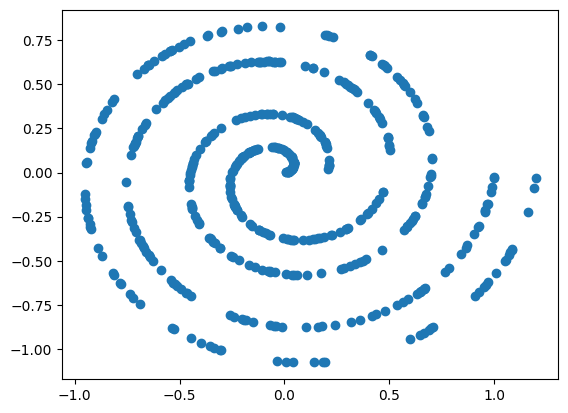

In [11]:
plot_x = train_x[:500]
plot_x.shape

plt.scatter(plot_x[:,0,0,0], plot_x[:,1,0,0])

# Case 3: Three turns

In [12]:
train_data = pd.read_csv("/content/swissroll-10000-turn3.csv", header=None)
train_data = train_data.to_numpy()

In [13]:
train_data = np.transpose(train_data)
train_data = torch.from_numpy(train_data)
print(train_data.shape)

train_num = train_data.shape[0]
torch.manual_seed(0)
permutation = torch.randperm(train_num)

train_x = train_data[permutation[:15000],:]
train_y = (permutation[:15000]<train_num/2)*1
train_x = train_x.reshape([train_x.shape[0],train_x.shape[1],1,1])
print(train_x.shape)
print(train_y.shape)

torch.Size([20000, 2])
torch.Size([15000, 2, 1, 1])
torch.Size([15000])


In [14]:
class SimplePerceptron(nn.Module):

    def __init__(self):
        super(SimplePerceptron, self).__init__()
        self.conv1 = nn.Conv2d(2,400,kernel_size = (1,1))
        self.conv2 = nn.Conv2d(400,400,kernel_size = (1,1))
        self.conv3 = nn.Conv2d(400,400,kernel_size = (1,1))
        self.conv4 = nn.Conv2d(400,400,kernel_size = (1,1))
        self.conv5 = nn.Conv2d(400,1,kernel_size = (1,1))

        self.bn1 = nn.BatchNorm2d(400, affine=False)
        self.bn2 = nn.BatchNorm2d(400, affine=False)
        self.bn3 = nn.BatchNorm2d(400, affine=False)
        self.bn4 = nn.BatchNorm2d(400, affine=False)


    def forward(self, x):

        #1st  layer
        #x = self.bn1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.conv5(x)
        #x = F.softmax(x)
        x = F.sigmoid(x)
        return x

    def forward_conv1(self, x):
        y = self.conv1(x)
        return (x,y)

    def forward_conv2(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        y = self.conv2(x)
        return (x,y)

    def forward_conv3(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        y = self.conv3(x)
        return (x,y)

    def forward_conv4(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        y = self.conv4(x)
        return (x,y)

    def forward_conv5(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)

        y = self.conv5(x)
        return (x,y)

In [15]:
model = SimplePerceptron().double()
print(count_parameters(model))

482801


In [16]:
#model.load_state_dict(torch.load("/content/FCC-swiss-roll-3turn-10k-large.pth"))
model.load_state_dict(torch.load("/content/FCC-swiss-roll-3turn-10k-large-corrected.pth"))
model.eval()

SimplePerceptron(
  (conv1): Conv2d(2, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(400, 1, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn2): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn3): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn4): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [17]:
(x_l1, y_l1) = model.forward_conv1(train_x)
(x_l2, y_l2) = model.forward_conv2(train_x)
(x_l3, y_l3) = model.forward_conv3(train_x)
(x_l4, y_l4) = model.forward_conv4(train_x)
(x_l5, y_l5) = model.forward_conv5(train_x)

In [19]:
#pd.DataFrame(x_l1[:,:,0,0].detach().numpy()).to_csv("model3-layer1-Xtrain.csv")
#pd.DataFrame(y_l1[:,:,0,0].detach().numpy()).to_csv("model3-layer1-Ytrain.csv")

#pd.DataFrame(x_l2[:,:,0,0].detach().numpy()).to_csv("model3-layer2-Xtrain.csv")
#pd.DataFrame(y_l2[:,:,0,0].detach().numpy()).to_csv("model3-layer2-Ytrain.csv")

#pd.DataFrame(x_l3[:,:,0,0].detach().numpy()).to_csv("model3-layer3-Xtrain.csv")
#pd.DataFrame(y_l3[:,:,0,0].detach().numpy()).to_csv("model3-layer3-Ytrain.csv")

#pd.DataFrame(x_l4[:,:,0,0].detach().numpy()).to_csv("model3-layer4-Xtrain.csv")
#pd.DataFrame(y_l4[:,:,0,0].detach().numpy()).to_csv("model3-layer4-Ytrain.csv")

#pd.DataFrame(x_l5[:,:,0,0].detach().numpy()).to_csv("model3-layer5-Xtrain.csv")
#pd.DataFrame(y_l5[:,:,0,0].detach().numpy()).to_csv("model3-layer5-Ytrain.csv")

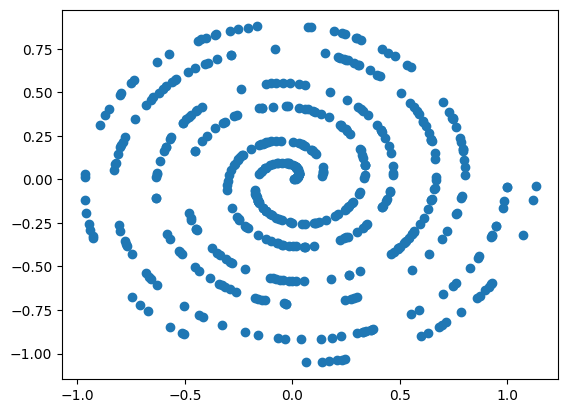

In [20]:
plot_x = train_x[:500]
plot_x.shape

plt.scatter(plot_x[:,0,0,0], plot_x[:,1,0,0])